In [1]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/analysis/derivatives/')

import importlib
import alchemical_derivatives as ad
importlib.reload(ad)
import glob
import numpy as np

from matplotlib import pyplot as plt
import scipy.interpolate as si

In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor rele

In [6]:
logdirs = glob.glob('/data/sahre/projects/atomic-energies/amons/amon_000004/ve_*/dE_*')

derivatives = {'lam':[], 'H1':[], 'H2':[], 'O3':[]}
dlam = 2e-5
for ve in ['ve_02', 've_03', 've_05', 've_06', 've_08']:
    for atom in ['lam', 'H1', 'H2', 'O3']:
        energies_el = []
        for pos in ['bw', 'fw']:
            energy_contributions, e_el_cpmd, nuc_rep_cpmd = ad.get_energy_contributions([f'/data/sahre/projects/atomic-energies/amons/amon_000004/{ve}/dE_d{atom}_{pos}/run.log'])
            # eoi = energy_contributions['N-L PSEUDOPOTENTIAL ENERGY ='][0]
            eoi = energy_contributions['KINETIC ENERGY ='][0]
            # eoi = energy_contributions['TOTAL ENERGY ='][0]
            # eoi = energy_contributions['EXCHANGE-CORRELATION ENERGY ='][0]
            # eoi = e_el_cpmd[0]
            energies_el.append(eoi)
        deri = (energies_el[1]-energies_el[0])/dlam
        derivatives[atom].append(deri)
# sorted_lam_vals, logfiles = sort_lambda_logfiles(logdirs)
# energy_contributions_H2, e_el_cpmd_H2, nuc_rep_cpmd_H2 = get_energy_contributions(logfiles_H2)
for k in derivatives.keys():
    derivatives[k].insert(0, 0.0)
    
energies_target = ad.get_energy_contributions([f'/data/sahre/projects/atomic-energies/amons/amon_000004/ve_08/run.log'])[0]
energies_ref = ad.get_energy_contributions([f'/data/sahre/projects/atomic-energies/amons/amon_000004/ve_00/run.log'])[0]

energies_exact = dict()

for k in energies_target.keys():
    energies_exact[k] = energies_target[k] - energies_ref[k]

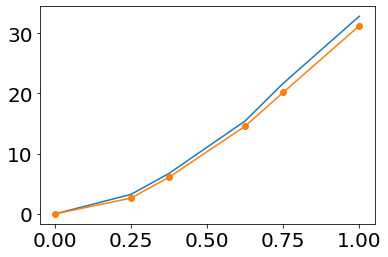

In [7]:
lambda_values = np.array([0,2,3,5,6,8])/8
plt.plot(lambda_values, np.array(derivatives['lam']))
plt.plot(lambda_values, np.array(derivatives['H1'])+np.array(derivatives['H1'])+np.array(derivatives['O3']), '-o')

Text(193.86818181818177, 0.5, '$\\sum_I \\partial E/\\partial V_I - \\partial E/\\partial \\lambda$ (mHa)')

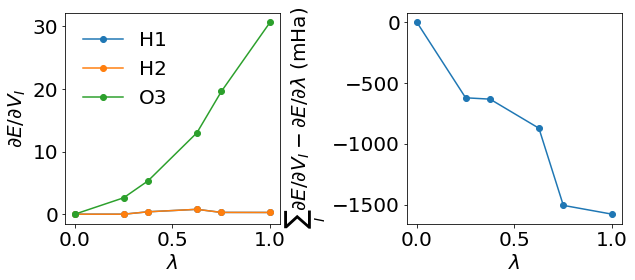

In [8]:
diff_deri = np.array(derivatives['H1'])+np.array(derivatives['H1'])+np.array(derivatives['O3']) - np.array(derivatives['lam'])

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,2)
fig.tight_layout()
fig.set_figwidth(10)
for k in derivatives:
    if k != 'lam':
        ax[0].plot(lambda_values, derivatives[k], '-o', label = k)


ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\partial E/\partial V_I$')
ax[0].legend(frameon = False)

ax[1].plot(lambda_values, 1000*diff_deri, '-o')
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel(r'$\sum_I \partial E/\partial V_I - \partial E/\partial \lambda$ (mHa)')

# plt.savefig('/home/sahre/projects/derivatives/figures/H2O_partial_derivatives.png', bbox_inches = 'tight', dpi = 300)

In [9]:
integrals_trapz = []
integrals_splines = []
splines = dict()
for k in derivatives:
    integrals_trapz.append(np.trapz(derivatives[k], lambda_values))
    splines[k] = si.CubicSpline(lambda_values, derivatives[k], axis=0, bc_type='not-a-knot', extrapolate=None)
    integrals_splines.append(splines[k].integrate(0,1))
integrals_trapz = np.array(integrals_trapz)
integrals_splines = np.array(integrals_splines)

Text(0, 0.5, '$E^{tot}_{alch} - E^{tot}_{exact}$ (mHa)')

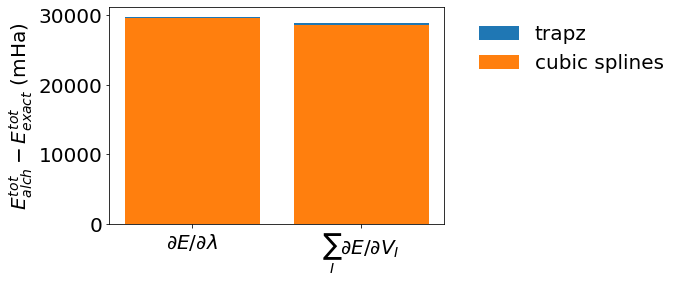

In [10]:
plt.bar([0,1], 1000*(np.array([integrals_trapz[0],integrals_trapz[1:].sum()])-energies_exact['TOTAL ENERGY =']),label = 'trapz' )
plt.bar([0,1], 1000*(np.array([integrals_splines[0],integrals_splines[1:].sum()])-energies_exact['TOTAL ENERGY =']) ,label = 'cubic splines')

plt.xticks([0,1],[r'$\partial E/\partial \lambda$', r'$\sum_I \partial E/\partial V_I$'])
plt.legend(bbox_to_anchor = (1.05,1), frameon=False)
plt.ylabel(r'$E^{tot}_{alch} - E^{tot}_{exact}$ (mHa)')

# plt.savefig('/home/sahre/projects/derivatives/figures/H2O_e_tot_error_trapz_splines.png', bbox_inches = 'tight', dpi = 300)

In [503]:
energy_contributions_t, e_el_cpmd, nuc_rep_cpmd = ad.get_energy_contributions([f'/data/sahre/projects/atomic-energies/amons/amon_000004/ve_08/dE_dO3_lam_t/run.log'])
energy_contributions_r, e_el_cpmd, nuc_rep_cpmd = ad.get_energy_contributions([f'/data/sahre/projects/atomic-energies/amons/amon_000004/ve_08/dE_dO3_lam_r/run.log'])

In [512]:
derivatives

{'lam': [0.0,
  -5.569999999999186,
  -9.277499999993388,
  -19.95849999998356,
  -26.907500000028502,
  -42.244000000124515],
 'H1': [0.0,
  -0.0989999999978508,
  -0.2330000000050347,
  -0.6695000000167539,
  -0.8789999999869734,
  -0.9949999999037117],
 'H2': [0.0,
  -0.0989999999978508,
  -0.2330000000050347,
  -0.6695000000167539,
  -0.8789999999869734,
  -0.9949999999037117],
 'O3': [0.0,
  -5.371999999992383,
  -8.812000000002485,
  -18.61949999999446,
  -25.149500000054555,
  -40.25450000000319]}

In [505]:
energy_contributions_t['TOTAL ENERGY =']-energy_contributions_r['TOTAL ENERGY =']

array([-21.51421655])

In [506]:
def subtract(contr, e_dict):
    sub = 0
    for k in contr:
        sub += e_dict[k]
    return(sub)

In [515]:
contr = ['KINETIC ENERGY =', '(PSEUDO CHARGE I-I) ENERGY =','(E-E) HARTREE ENERGY =', 'EXCHANGE-CORRELATION ENERGY =', 'GRADIENT CORRECTION ENERGY =']
(energy_contributions_t['TOTAL ENERGY ='] - subtract(contr, energy_contributions_t)) - (energy_contributions_r['TOTAL ENERGY ='] - subtract(contr, energy_contributions_r))

array([-40.71563506])

In [518]:
-40.71563506+40.25450000000319

-0.46113505999680626

In [520]:
-11.67629843-9.69683763-9.81225052-5.02949629

-36.21488287

In [510]:
energy_contributions_t

{'TOTAL ENERGY =': array([-14.95216818]),
 'KINETIC ENERGY =': array([9.23482584]),
 'ELECTROSTATIC ENERGY =': array([-11.67629843]),
 '(E+I)-(E+I) HARTREE ENERGY =': array([0.29196998]),
 '(PSEUDO CHARGE I-I) ENERGY =': array([9.69683763]),
 '(E-E) HARTREE ENERGY =': array([9.81225052]),
 'ESELF =': array([11.96826841]),
 'ESR =': array([0.]),
 'LOCAL PSEUDOPOTENTIAL ENERGY =': array([-10.68431569]),
 'N-L PSEUDOPOTENTIAL ENERGY =': array([1.15915265]),
 'EXCHANGE-CORRELATION ENERGY =': array([-2.98553254]),
 'GRADIENT CORRECTION ENERGY =': array([-0.09321259])}

In [513]:
energy_contributions_r

{'TOTAL ENERGY =': array([6.56204837]),
 'KINETIC ENERGY =': array([3.32066108]),
 'ELECTROSTATIC ENERGY =': array([5.02949629]),
 '(E+I)-(E+I) HARTREE ENERGY =': array([5.02949629]),
 '(PSEUDO CHARGE I-I) ENERGY =': array([0.]),
 '(E-E) HARTREE ENERGY =': array([5.02949629]),
 'ESELF =': array([0.]),
 'ESR =': array([0.]),
 'LOCAL PSEUDOPOTENTIAL ENERGY =': array([0.]),
 'N-L PSEUDOPOTENTIAL ENERGY =': array([0.06182616]),
 'EXCHANGE-CORRELATION ENERGY =': array([-1.84993516]),
 'GRADIENT CORRECTION ENERGY =': array([-0.03647186])}

In [498]:
energy_dens = np.loadtxt('/data/sahre/projects/atomic-energies/amons/amon_000004/atomic_energies_pp.txt')

energy_dens[:,5].sum()

-27.197410832752738

In [327]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/atomic_force_field/')

import alchemical_decomposition as ad

sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')

import utils_qm as uqm

from parse_density_files import CUBE

In [328]:
cube = CUBE('/data/sahre/projects/atomic-energies/amons/amon_000004/cube-files/ve_08.cube')

In [334]:
density_grid = np.array(cube.get_grid())
np.save('/data/sahre/projects/atomic-energies/amons/amon_000004/density_grid.npy', density_grid)

In [336]:
np.save('/data/sahre/projects/atomic-energies/amons/amon_000004/hmatrix.npy', cube.get_hmatrix())

In [337]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/atomic_force_field/')

import alchemical_decomposition as ad

sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')

import utils_qm as uqm

from parse_density_files import CUBE

import os
import numpy as np

comp_name = 'amon_000004'

###########################################################
#  gather data for compound
###########################################################

# contains the data necessary to calculate atomic energies
# is used to initialize an AlchemicalMolecule object
datadict = dict()

# get lambda values
lam_vals = np.array([0, 2, 3, 5, 6, 8])/8
datadict['lam_vals'] = lam_vals

# get density grid
density_grid = np.load('/data/sahre/projects/atomic-energies/amons/amon_000004/density_grid.npy')
datadict['density_grid'] = density_grid

# get hmatrix
hmatrix =np.load('/data/sahre/projects/atomic-energies/amons/amon_000004/hmatrix.npy')
datadict['hmatrix'] = hmatrix

# read molecule specific information (densities, charge and position of nuclei) necessary to calculate atomic energies
comp_base_dir = '/data/sahre/projects/atomic-energies/amons'
compound_path = os.path.join(comp_base_dir, comp_name)
cube_files = ['ve_02.cube', 've_03.cube', 've_05.cube', 've_06.cube', 've_08.cube']

densities = []
nuclei = []
for cube_file in cube_files:
    cube_path = compound_path + '/cube-files/' + cube_file
    
    # needed because some cube-files are named ve_8.cube instead of ve_08.cube
    if cube_file == 've_08.cube':
        if not os.path.isfile(cube_path):
            cube_path = cube_path.replace('ve_08', 've_8')
        
    assert os.path.isfile(cube_path), f'{cube_path} does not exist'
    
    cube_object = CUBE(cube_path)
    
    N = 8/cube_object.data_scaled.sum()
    
    densities.append(N*cube_object.data_scaled)
    
    if cube_file == 've_08.cube':
        nuclei = cube_object.atoms

# add the density of the uniform electron gas
num_gpt = densities[0].shape[0]*densities[0].shape[1]*densities[0].shape[2]
num_ve = densities[-1].sum()
ueg = np.full_like(densities[0], fill_value=num_ve/num_gpt)
densities.insert(0, ueg)
datadict['densities'] = densities

# initialize alchemical atoms

nuclear_charges = nuclei[:,0]
positions = nuclei[:, 1:4]
AlchAtoms = []
pp_parameters = uqm.load_obj('/data/sahre/projects/atomic-energies/parameters/pp_parameters.dict')
for Z, position in zip(nuclear_charges, positions):
    AlchAtoms.append(ad.AlchemicalAtom({'Z':Z, "position":position, "pp_parameters":pp_parameters[Z]}))
datadict['AlchAtoms'] = AlchAtoms

###########################################################
# create alchemical molecule
###########################################################

alchMol = ad.AlchemicalMolecule(datadict)

###########################################################
# calculate atomic energy
###########################################################

alchMol.calculate_atomic_energies(lambda_intg='trapz', potential='pp') # pseudopotential
energies_pp = alchMol.atomic_energies.copy()

alchMol.calculate_atomic_energies(lambda_intg='trapz', potential='coulomb_ZV') # coolomb potential
energies_coul = alchMol.atomic_energies.copy()

###########################################################
# save atomic energy data
###########################################################

store = np.array([nuclei[:,0], alchMol.get_ZV(), nuclei[:,1], nuclei[:,2], nuclei[:,3], energies_pp, energies_coul]).T
header = 'nuclear charge\t nuclear valence charge\t x_coord\t y_coord\t z_coord\t atomic energy pp\t atomic energy coulomb\t'
save_dir = os.path.join(compound_path, 'atomic_energies_pp.txt')
np.savetxt(save_dir, store, delimiter='\t', header = header)